In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments.batched_online import simulate, make_key

from utils import ipr, entropy, entropy_sort, mean_sort, var_sort, plot_receptive_fields, plot_rf_evolution

def simulate_or_load(**kwargs):
    path_key = make_key(**kwargs)
    if path_key + '.npz' in os.listdir('../localization/results/weights'):
        print('Already simulated')
        data = np.load('../localization/results/weights/' + path_key + '.npz', allow_pickle=True)
        weights_, metrics_ = data['weights'], data['metrics']
    else:
        print('Simulating')
        weights_, metrics_ = simulate(**kwargs)
    return weights_, metrics_

In [64]:
config_ = dict(
  seed=0,
  num_dimensions=20,
  init_scale=1e-2,
  model_cls=models.SimpleNet,
  optimizer_fn=optax.sgd,
  batch_size=40,
  dataset_cls=datasets.FiniteDataset,
  # batch_size=1000,
  # dataset_cls=datasets.SinglePulseDataset,
  support=(-1, 1),
  class_proportion=0.5,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  save_=True,
  xi1=5,#25,#10,
  xi2=3,#13,#5,
  # xi1=(0.25,0.275),
  # xi2=(0.125,0.15),
  activation='relu',
)

Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'batch_size': 40,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.finite_dataset.FiniteDataset'>,
 'evaluation_interval': None,
 'gain': None,
 'init_fn': <function xavier_normal_init at 0x155ee6c00>,
 'init_scale': 0.01,
 'kwargs': {},
 'learning_rate': 0.025,
 'model_cls': <class 'localization.models.feedforward.SimpleNet'>,
 'num_dimensions': 20,
 'num_epochs': 5000,
 'num_hiddens': 2,
 'optimizer_fn': <function sgd at 0x154c87f60>,
 'sampler_cls': <class 'localization.samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 0,
 'support': (-1, 1),
 'use_bias': False,
 'wandb_': False,
 'xi1': 5,
 'xi2': 3}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 200000
Length of eval dataset: 1000
Length of train sampler: 200000
Length of eval sampler: 1000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[2,20],
    bias=None,
    in_features=20,
    out_features=2,
  

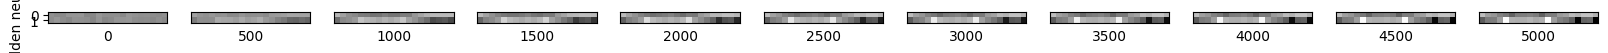

In [65]:
config = config_.copy()
config['num_hiddens'] = 2
config['learning_rate'] = 0.025
config['num_epochs'] = 5000
config['use_bias'] = False

weights100, metrics100 = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights100, num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

In [77]:
dataset = datasets.FiniteDataset(key=jax.random.PRNGKey(0), **config)
x, y = dataset[:80]

kwargs: {'seed': 0, 'init_scale': 0.01, 'model_cls': <class 'localization.models.feedforward.SimpleNet'>, 'optimizer_fn': <function sgd at 0x154c87f60>, 'batch_size': 40, 'dataset_cls': <class 'localization.datasets.finite_dataset.FiniteDataset'>, 'sampler_cls': <class 'localization.samplers.base.EpochSampler'>, 'init_fn': <function xavier_normal_init at 0x155ee6c00>, 'save_': True, 'activation': 'relu', 'num_hiddens': 2, 'learning_rate': 0.025, 'num_epochs': 5000, 'use_bias': False}


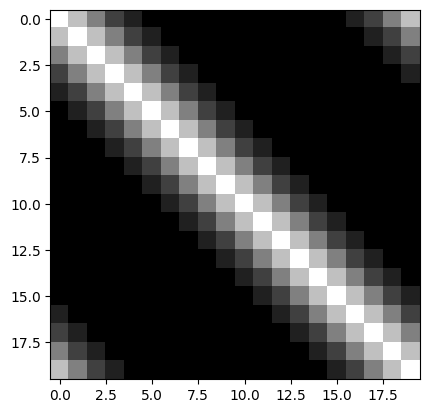

In [78]:
plt.imshow((x.T @ x) / 80, cmap='gray')

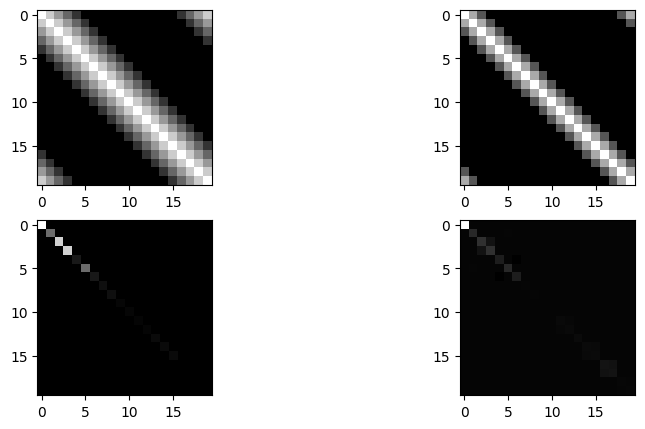

In [90]:
x1 = x[y==1]
x2 = x[y==0]
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
xx1 = (x1.T @ x1) / 40
axs[0,0].imshow(xx1, cmap='gray')
xx2 = (x2.T @ x2) / 40
axs[0,1].imshow(xx2, cmap='gray')
e1, v1 = np.linalg.eig(xx1)
e2_ = v1.T @ xx2 @ v1
axs[1,0].imshow(np.diag(e1), cmap='gray')
axs[1,1].imshow(e2_, cmap='gray')

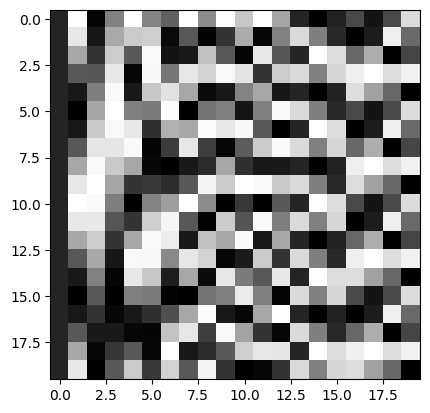

In [93]:
plt.imshow(v1, cmap='gray')

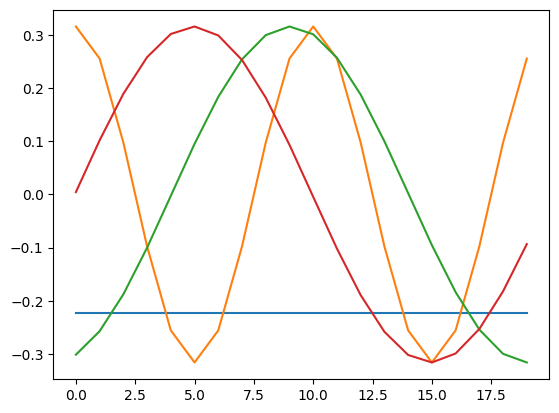

In [99]:
plt.plot(v1[:,:4])

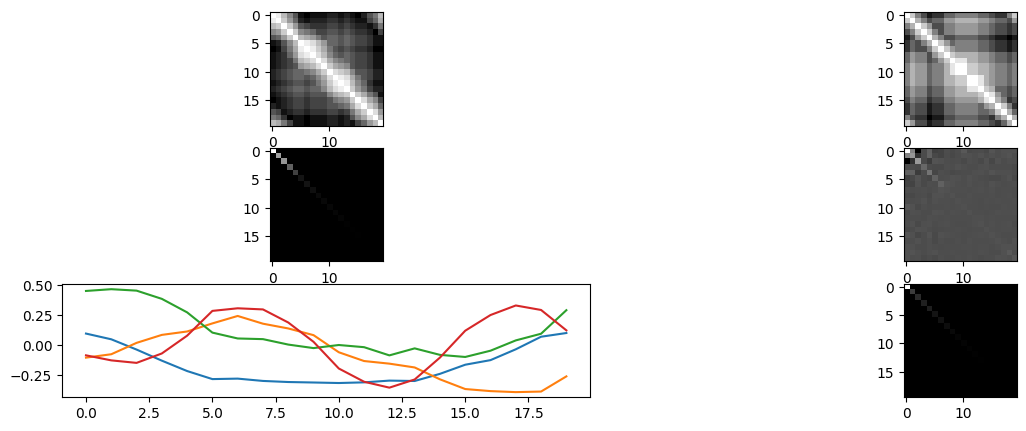

In [116]:
g = np.random.randint(0, 2, size=(x.shape[0],1))
# g = np.ones((x.shape[0],1))
x1 = x[y==1] * g[y==1]
x2 = x[y==0] * g[y==0]
fig, axs = plt.subplots(3, 2, figsize=(15, 5))
xx1 = (x1.T @ x1) / 40
axs[0,0].imshow(xx1, cmap='gray')
xx2 = (x2.T @ x2) / 40
axs[0,1].imshow(xx2, cmap='gray')
e1, v1 = np.linalg.eig(xx1)
e2_ = v1.T @ xx2 @ v1
axs[1,0].imshow(np.diag(e1), cmap='gray')
axs[1,1].imshow(e2_, cmap='gray')
axs[2,0].plot(v1[:,:4])
e2, v2 = np.linalg.eig(xx2)
axs[2,1].imshow(np.diag(e2).real, cmap='gray')

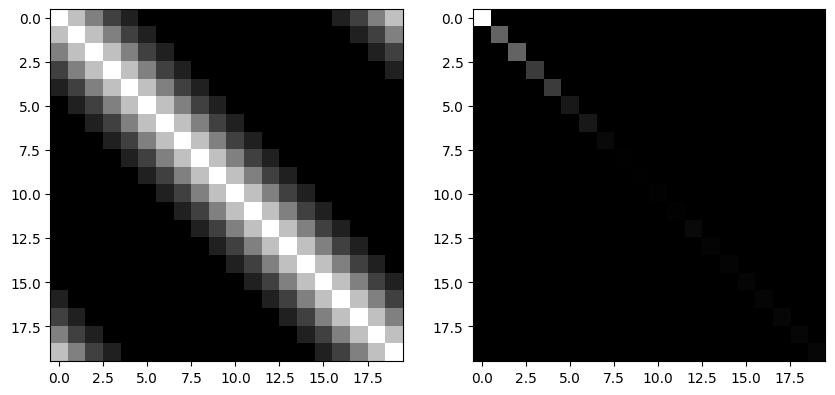

In [142]:
g = np.random.randint(0, 2, size=(x.shape[0],1))
g = np.ones((x.shape[0],1))
x_ = x * g
xx_ = (x_.T @ x_) / 80
e_, v_ = np.linalg.eig(xx_)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(xx_, cmap='gray')
axs[1].imshow(np.diag(e_), cmap='gray')

In [143]:
e_

array([7.4       , 2.8853989 , 2.8853989 , 1.7326238 , 1.7326238 ,
       0.7159027 , 0.7159027 , 0.26180336, 0.03819658, 0.03819658,
       0.06606328, 0.06606328, 0.26180336, 0.13263509, 0.13263509,
       0.16737618, 0.16737618, 0.19999997, 0.20000003, 0.19999997],
      dtype=float32)

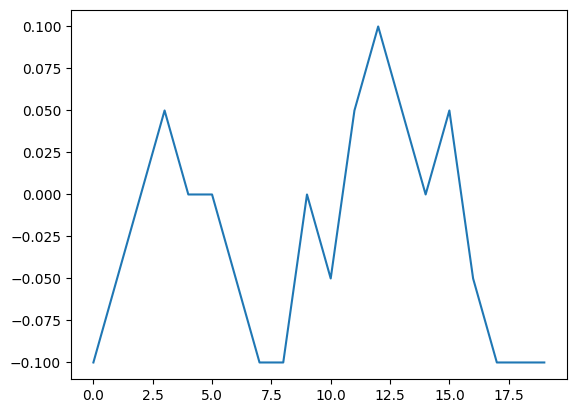

In [118]:
plt.plot( np.mean(x1, axis=0) )

In [121]:
U, S, Vh = np.linalg.svd( np.mean(x1, axis=0).reshape(1, -1) )

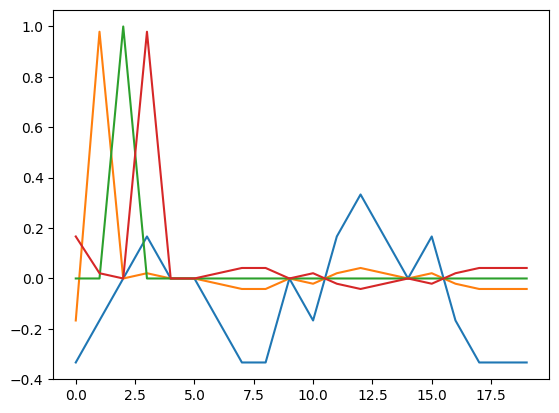

In [134]:
plt.plot(Vh[:,:4])

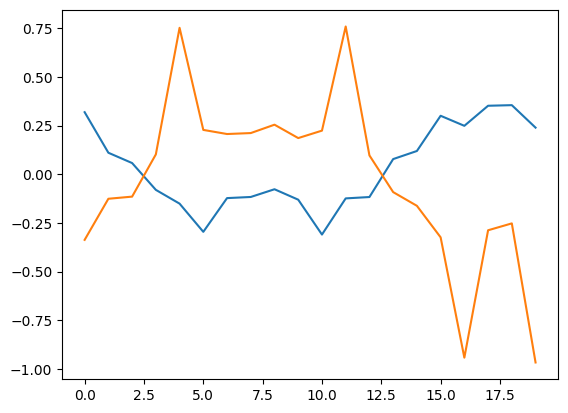

In [66]:
plt.plot(weights100[-1].T)

In [16]:
config__ = config.copy()
config__['dataset_cls'] = datasets.SinglePulseDataset
config__['xi1'] = (0.4,0.5)
config__['xi2'] = (0.3,0.4)
dataset = datasets.SinglePulseDataset(key=jax.random.PRNGKey(0), **config__)
x, y = dataset[:25]
print(x[:10], y[:10])

kwargs: {'seed': 0, 'init_scale': 0.01, 'model_cls': <class 'localization.models.feedforward.SimpleNet'>, 'optimizer_fn': <function sgd at 0x154c87f60>, 'batch_size': 40, 'dataset_cls': <class 'localization.datasets.single_pulse.SinglePulseDataset'>, 'sampler_cls': <class 'localization.samplers.base.EpochSampler'>, 'init_fn': <function xavier_normal_init at 0x155ee6c00>, 'save_': True, 'activation': 'relu', 'num_hiddens': 10, 'learning_rate': 5.0, 'num_epochs': 5000, 'use_bias': False}
[[-1. -1. -1.  1.  1.  1.  1.  1. -1. -1.]
 [-1. -1. -1. -1.  1.  1.  1.  1.  1. -1.]
 [-1. -1. -1.  1.  1.  1.  1.  1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1.  1.  1.  1.  1.]
 [-1. -1.  1.  1.  1.  1.  1.  1. -1. -1.]
 [-1.  1.  1.  1.  1.  1.  1. -1. -1. -1.]
 [ 1.  1.  1.  1. -1. -1. -1. -1.  1.  1.]
 [-1. -1. -1. -1. -1.  1.  1.  1.  1.  1.]
 [-1. -1.  1.  1.  1.  1.  1. -1. -1. -1.]
 [ 1.  1.  1. -1. -1. -1. -1.  1.  1.  1.]] [1. 1. 1. 1. 0. 0. 0. 1. 1. 0.]


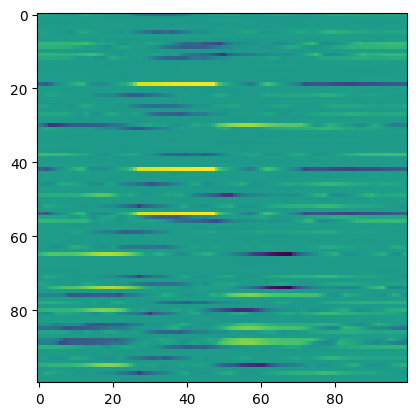

In [46]:
plt.imshow(weights100[-1])

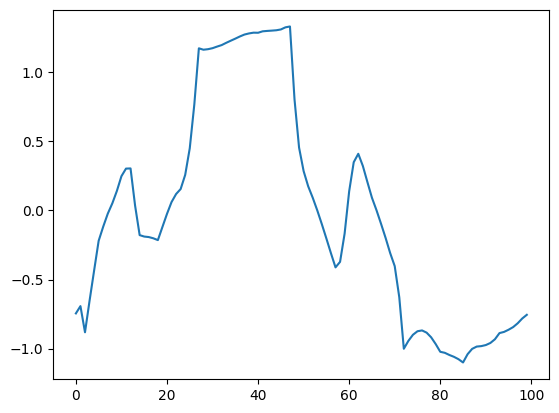

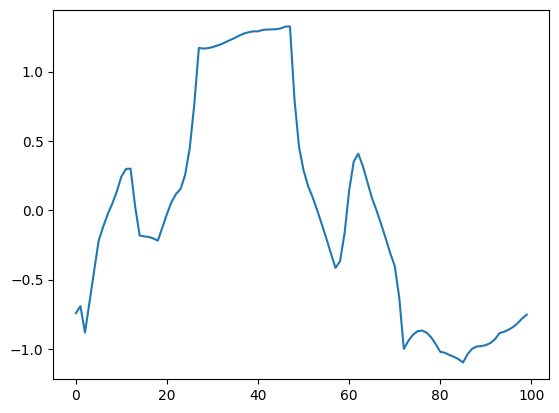

In [50]:
plt.plot( weights100[-1,19] )
plt.show()
plt.plot( weights100[-1,42] )

In [55]:
x = np.zeros(10)
x[3:7] = 1
np.outer(x,x)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])